## Загрузка данных

В .csv файле на Яндекс.Диске данные хранятся в формате: event_id, participant_1, participant_2.

Такое представление не позволяет осмысленно отразить их в виде графа, поэтому вносить в графовую БД их нужно будет в другом виде.

In [86]:
import time

from nebula3.gclient.net import ConnectionPool
from nebula3.Config import Config
from nebula3.common import *

import pandas as pd
import requests 
from urllib.parse import urlencode
from zipfile import ZipFile
from io import BytesIO

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/s6wWqd8Ol_5IvQ' 

# получаем url
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# возвращает zip-папку, из которой ещё нужно извлечь сам .csv
download_response = requests.get(download_url)

this_zip = ZipFile(BytesIO(download_response.content))
events_filepath = this_zip.open(this_zip.namelist()[0])

In [87]:
events = pd.read_csv(events_filepath, sep=';', header=0)
events

,id события,ФИО участника события 1,ФИО участника события 2
0,189,Галчевская Карина Владимировна,Белоновская Анастасия Семеновна
1,206,Офицеров Олег Романович,Сапожник Борис Валерьевич
2,445,Жандарова Лариса Германовна,Чемодуров Дамир Русланович
3,503,Масимова Яна Дамировна,Мингажетдинов Рамиль Семенович
4,571,Мухтарова Алена Яковлевна,Щербатенко Ольга Робертовна
...,...,...,...
4995,999333,Осташов Владимир Данилович,Чалов Илья Владимирович
4996,999360,Гандыбина Любовь Александровна,Мерлин Илья Юрьевич
4997,999403,Востоков Виктор Ильдарович,Аликас Никита Андреевич
4998,999405,Огарева Людмила Ильдаровна,Нагайцева Алина Степановна


## Открыть соединение с Nebula
Для этого Nebula нужно запустить через Docker и открыть на локальном хосте.

In [3]:
ip = '127.0.0.1'
port = 9669

config = Config()
connection_pool = ConnectionPool()
assert connection_pool.init([(ip, port)], config)

client = connection_pool.get_session('root', 'nebula')
assert client is not None

# создание Space, тэгов, рёбер графа и их свойств
client.execute(
    'CREATE SPACE IF NOT EXISTS events(vid_type=FIXED_STRING(100)); USE events;'
    'CREATE TAG IF NOT EXISTS person(name string);'
    'CREATE TAG IF NOT EXISTS event(id int);'
    'CREATE EDGE p (participate int);'
)

time.sleep(5)

## Вставка значений
Вставлять ФИО участников событий в вершины person; id событий - в вершины event; соединять события и их участников ребром p (participate = 1).

In [4]:
for i in range(events.shape[0]):
    event_id, prt_1, prt_2 = events.iloc[i].values

    client.execute(
        'INSERT VERTEX event (id) VALUES "{}":({});'.format(event_id, event_id)
    )
    
    client.execute(
        'INSERT VERTEX person (name) VALUES "{}":("{}"), "{}":("{}");'.format(prt_1, prt_1, prt_2, prt_2)
    )
    
    client.execute(
        'INSERT EDGE p (participate) VALUES "{}"->"{}":(1), "{}"->"{}":(1);'.format(prt_1, event_id, prt_2, event_id)
    )

# закрыть соединение
connection_pool.close()

Closing a connection that is in use


# Анализ
## Визуальный анализ
В каждом событии принимает участие только 2 человека. Подавляющее большинство сотрудников принимали участие только в одном событии. На графе это изображено в виде ломаной **"ФИО 1" - id события - "ФИО 2"**:

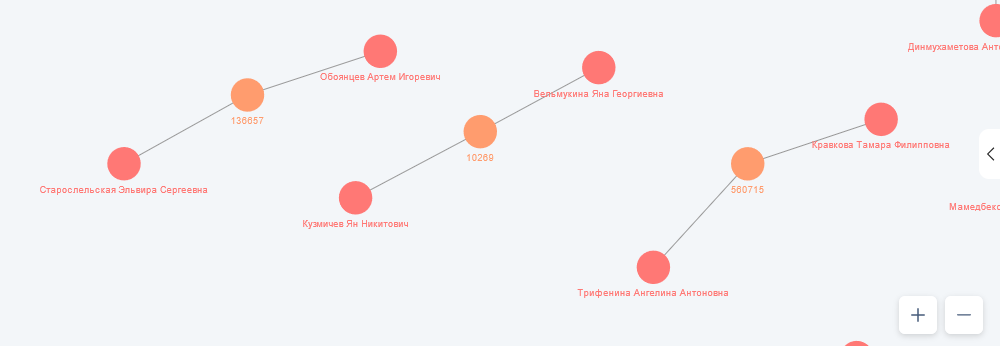

Однако есть исключения - люди, принявшие участие в более чем одном событии:

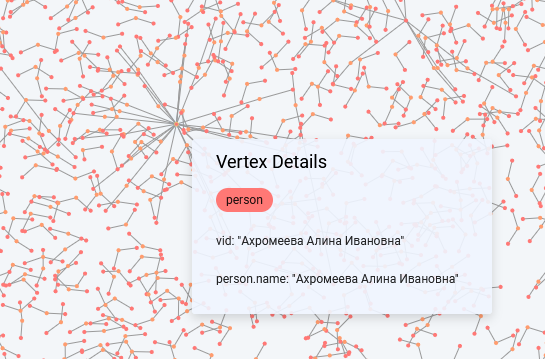

Например:
- Ахромеева Алина Ивановна;
- Медведева Дарья Алексеевна;
- Пафомова Кира Вадимовна;
- Диомидов Игорь Ильдарович;
- Башнина Антонина Глебовна;
- Шолохов Игорь Робертович;

## Алгоритмический анализ
Для каждого участника найдём количество событий, в которых он принимал участие, и выведем на экран тех, кто участвовал более чем в одном событии.

In [20]:
s1, s2 = events['ФИО участника события 1'].value_counts(), events['ФИО участника события 2'].value_counts()

for i, v in zip(s2.index, s2.values):
    if i in s1.index:
        s1.loc[i] += v
    else:
        pd.concat([s1, pd.Series(v, index=[i])], axis='index', ignore_index=True)

s1.name = "Участники более чем 1 события"
result = s1[s1.values > 1]
print(result)
print(len(result), 'сотрудников всего')

Ахромеева Алина Ивановна             50
Башнина Антонина Глебовна            14
Диомидов Игорь Ильдарович             5
Зимнухова Карина Даниловна            5
Пафомова Кира Вадимовна               3
Шолохов Игорь Робертович              4
Батиевская Ангелина Романовна         2
Яцкой Роберт Ильдарович               2
Троекуров Глеб Ефимович               2
Каехтин Ильдар Эдуардович             2
Радионова Тамара Ярославовна          2
Ляуданский Валентин Владиславович     2
Рыскина Эльмира Ивановна              2
Бугайчук Роман Эдуардович             2
Мараховская Дарья Романовна           2
Подолян Владислав Денисович           2
Дорожкин Анатолий Егорович            2
Торгунаков Роман Кириллович           2
Поскребышев Яков Дмитриевич           2
Медведева Дарья Алексеевна            6
Недовесков Владимир Иванович          2
Нагайцева Анжелика Яновна             2
Ивашев Вячеслав Игоревич              2
Даниленко Владимир Семенович          2
Двигубская Валентина Геннадьевна      3
